# Drugi domaći zadatak iz predmeta 13E044DOS - Digitalna obrada slike
<hr>
<p style="font-size:20px">Viktor Todosijević 0050/2017</p>

## Prvi zadatak
<hr>

Automatsko numerisanje jednačina

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from skimage.feature.peak import peak_local_max
from skimage.exposure import rescale_intensity
from matplotlib.patches import Circle
import time
from IPython.display import clear_output


%matplotlib inline

from IPython.display import display, HTML

HTML centriranje plotova

In [3]:
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.

Euklidsko rastojanje u tački $(u, v)$ kvadrirano<br>
\begin{equation} \label{euclid_distance}
D^2(u, v) = {u^2 + v^2}
\end{equation}


In [4]:
def distance_sqrd(X, Y, xx, yy):
    D = ((X - xx) ** 2 + (Y - yy) ** 2)
    D = D.astype(np.float32)
    return D

Notch filtar - nepropusnik određenog niza opsega. Svaki član filtra je tipa ili idealnog ili Batervortovog ili Gausovog visokofrekventnog filtra.

In [5]:
def notch_filter(filter_name, peaks, height, width, radius, D0, order):
    
    H = np.ones((height, width))
    min_dist = 50
    for i in range(len(peaks)):
        # skip DC
        if np.abs(peaks[i, 0] - Q / 2) < min_dist and np.abs(
                peaks[i, 1] - P / 2) < min_dist:
            continue

        D_sqrd = distance_sqrd(X, Y, peaks[i, 1], peaks[i, 0])

        if filter_name == 'ideal':
            H[D_sqrd < radius**2] = 0

        if filter_name == 'gauss':
            H[D_sqrd < radius ** 2] = H[D_sqrd < radius ** 2] * (1 - np.exp(-D_sqrd[D_sqrd < radius ** 2] / 2 / D0 ** 2))

        if filter_name == 'butter':
            H[D_sqrd < radius ** 2] = H[D_sqrd < radius ** 2] * (1 - 1 / (1 + D_sqrd[D_sqrd < radius ** 2] ** order / D0 ** (2 * order)))
        
        clear_output(wait=True)
        print(i, " / ", len(peaks), end="\r")

    H[H < 0] = 0
    return H

Niskofrekventni filtri<br>

Neka je $D(u, v)$ euklidsko rastojanje od koordinatnog početka u tački $(u, v)$ dato formulom (\ref{euclid_distance}). Tada su formule implementiranih  niskofrekventinih filtara sledeće:


<br>
Idealni filtar
\begin{equation} \label{ideal_nf}
H(u, v) = 
\begin{cases}
    1, & D(u, v) < R \\ 
    0, & D(u, v) \geq R          
\end{cases}
\end{equation}

Gauss-ov filtar
\begin{equation} \label{gauss_nf}
H(u, v) = e^{-\displaystyle\frac{D^2(u, v)}{2D_0^2}}
\end{equation}

Butterworth-ov filtar
\begin{equation} \label{butterworth_nf}
H(u, v) = \frac{1}{1 + {\left(\displaystyle\frac{D(u, v)}{D_0}\right)}^{2n}}
\end{equation}


gde su $D_0$, $n$ i $R$ parametri filtara.

In [6]:
def lowpass_filter(name, dim_tuple, D0=1000, order=2, R = 100):
    Q = dim_tuple[0]
    P = dim_tuple[1]
    
    x = np.arange(0, P, 1)
    y = np.arange(0, Q, 1)

    X, Y = np.meshgrid(x, y)
    
    D_sqrd = distance_sqrd(X, Y, P/2, Q/2) # euklidsko rastojanje od centra slike

    H_lp = np.zeros((Q, P), dtype=np.float32)
    
    if name == 'butter':
        H_lp = 1 / (1 + D_sqrd**order / D0**(2 * order))

    if name == 'gauss':
        H_lp = np.exp(-D_sqrd / 2 / D0 ** 2)
    
    if name == 'ideal':
        H_lp[D_sqrd < R**2] = 1

    return H_lp.astype(np.float32)

Prikaz spektra kao $log(1 + |F|)$

In [7]:
def log_abs_F_foo(F):
    return np.log(1 + np.abs(F))

### Učitavanje

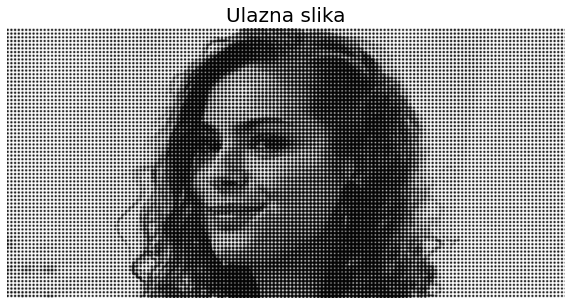

In [8]:
img = io.imread('sekvence/girl_ht.tif')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Ulazna slika nastala postupkom polutoniranja gde se štampanjem crnih i belih polja različite veličine ostvaruje utisak različitih nijansi sive.

Dimenzije slike

In [9]:
N = img.shape[0]  # N   rows    y
M = img.shape[1]  # M   columns x

Proširujemo sliku kako bismo dobili spektar veće rezolucije

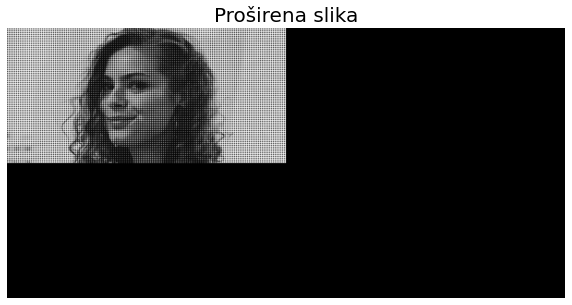

In [10]:
padded_img = np.zeros((2 * N, 2 * M))
Q = padded_img.shape[0]  # 2*N   rows    y
P = padded_img.shape[1]  # 2*M   columns x
padded_img[0:N, 0:M] = img

plt.figure(figsize=figsize)
plt.imshow(padded_img, cmap='gray')

plt.title('Proširena slika', fontsize=fontsize)
plt.axis('off')
plt.show()

### Analiza u frekvencijskom domenu

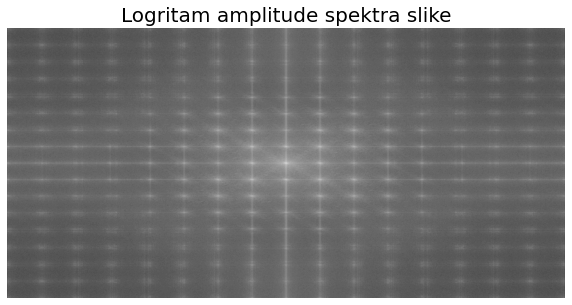

In [11]:
F = fftshift(fft2(padded_img))
log_abs_F = log_abs_F_foo(F)

plt.figure(figsize=figsize)
plt.imshow(log_abs_F, cmap='gray')

plt.title('Logritam amplitude spektra slike', fontsize=fontsize)
plt.axis('off')
plt.show()

Uočavamo veliki broj ravnomerno raspoređenih pikova u spektru i sumnjamo da oni potiču od tačkica čije prisustvo hoćemo da prikrijemo.

Prva stvar koju možemo da uradimo je da primenimo niskofrekventni filtar i da se otarasimo komponenti na jako visokim frekvencijama kako bismo smanjili broj pikova koji moramo da odstranimo.

In [12]:
H_lp = lowpass_filter('butter', (Q, P), D0=700, order=4, R=1000)
F_lowpassed = F * H_lp
log_abs_F_lowpassed = log_abs_F_foo(F_lowpassed)

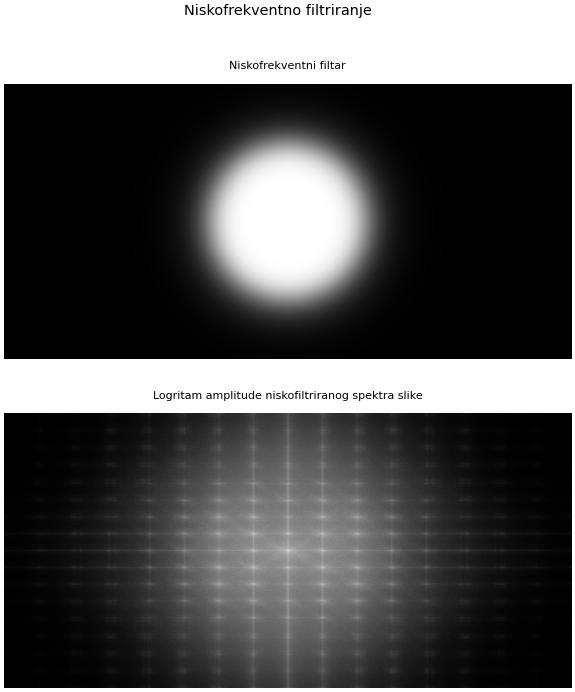

In [13]:
# subplot_figsize = (30, 8)
subplot_figsize = (20,20)
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);

suptitle_scale = 1.3

ax[0].imshow(H_lp, cmap='gray')
ax[0].set_title("Niskofrekventni filtar\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(log_abs_F_lowpassed, cmap='gray')
ax[1].set_title("Logritam amplitude niskofiltriranog spektra slike\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Niskofrekventno filtriranje", fontsize= suptitle_scale * fontsize)
plt.show()

# TODO Videti za velicinu fonta. 

Sledeće šta treba da uradimo je da lociramo vrhove spektra i da odstranimo sve osim onog koji odgovara DC komponenti.

In [14]:
peaks = peak_local_max(log_abs_F_lowpassed,
                       min_distance=100,
                       threshold_abs=0,
                       threshold_rel=0.3,
                       exclude_border=True,
                       indices=True,
                       num_peaks=np.inf,
                       footprint=None,
                       labels=None)


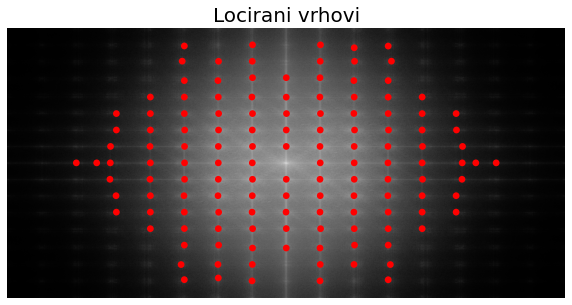

In [15]:
fig, ax = plt.subplots(1, figsize=figsize)
ax.imshow(log_abs_F_lowpassed, cmap='gray')

# crtanje krugova
dist_min = 50
for i in range(len(peaks)):
    if np.abs(peaks[i, 0] - Q / 2) < dist_min and np.abs(
            peaks[i, 1] - P / 2) < dist_min:
        continue
    circ = Circle((peaks[i, 1], peaks[i, 0]), 30,  facecolor='r')
    ax.add_patch(circ)

plt.title("Locirani vrhovi", fontsize=fontsize)
plt.axis('off')
plt.show()

In [16]:
x = np.arange(0, P, 1)
y = np.arange(0, Q, 1)

X, Y = np.meshgrid(x, y)

start_time = time.time()

radius = 250
D0 = radius / 3
order = 2
H_notch = notch_filter(filter_name='gauss', 
                 peaks=peaks, 
                 height=Q, 
                 width=P, 
                 radius=radius, 
                 D0=D0, 
                 order=order)

print("Vreme = " + "%.1f" % (time.time() - start_time) + " sec")

Vreme = 22.0 sec


In [17]:
F_notched = F_lowpassed * H_notch
log_abs_F_notched = log_abs_F_foo(F_notched)

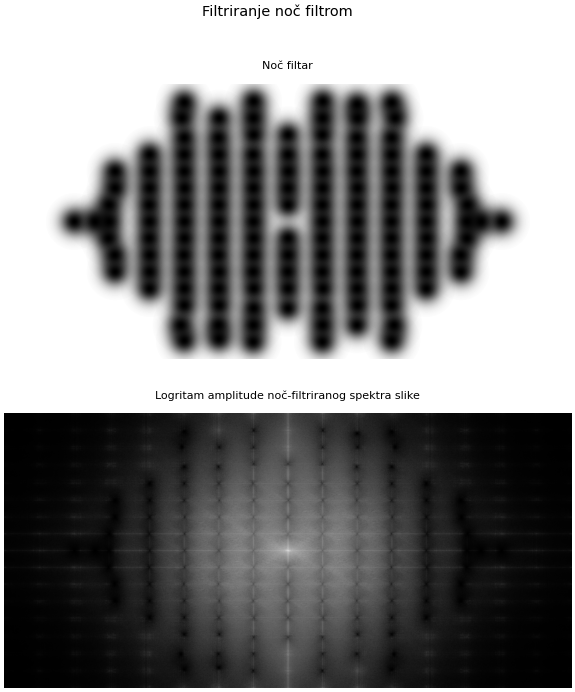

In [18]:
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);


ax[0].imshow(H_notch, cmap='gray')
ax[0].set_title("Noč filtar\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(log_abs_F_notched, cmap='gray')
ax[1].set_title("Logritam amplitude noč-filtriranog spektra slike\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Filtriranje noč filtrom", fontsize= suptitle_scale * fontsize)
plt.show()

Inverzna transformacija

In [19]:
img_filtered_padded = np.real(ifft2(ifftshift(F_notched)))
img_filtered = img_filtered_padded[0:N, 0:M]

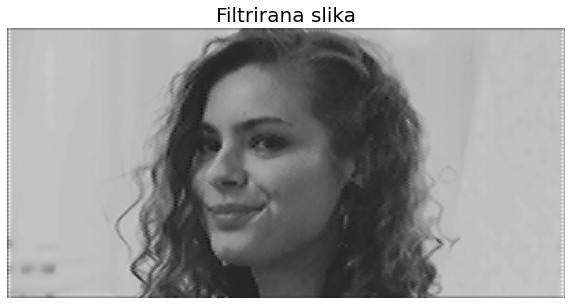

In [20]:
plt.figure(figsize=figsize)
plt.imshow(img_filtered, cmap='gray')

plt.title('Filtrirana slika', fontsize=fontsize)
plt.axis('off')
plt.show()

### Popravka kontrasta

In [21]:
hist_f, bin_edges = np.histogram(img_filtered.flatten(),
                                 bins=256, range=(np.amin(img_filtered), np.amax(img_filtered)))

Zasitimo piksele koji odgovaraju najvišem vrhu na maksimalnu vrednost jer oni odgovaraju pozadini. Zasitimo i određeni broj piksela na minimalnu vrednost radi boljeg kontrasta.

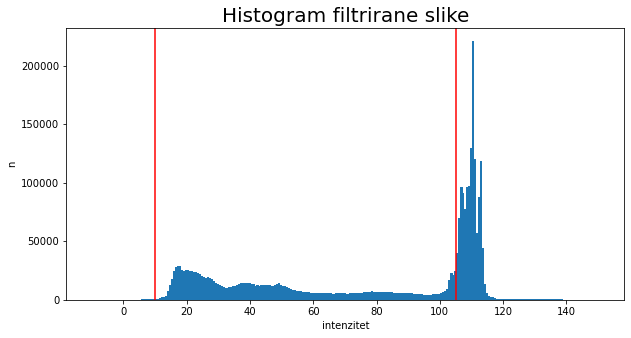

In [22]:
in_min = 10
in_max = 105

fig = plt.figure(figsize=(10, 5))
plt.bar(bin_edges[0:-1], hist_f)

fig.gca().axvline(x=in_min, color='r')
fig.gca().axvline(x=in_max, color='r')
plt.title('Histogram filtrirane slike', fontsize=fontsize)
plt.xlabel('intenzitet')
plt.ylabel('n')
plt.show()


In [23]:
img_contrast_stretched = np.array(img_filtered)

img_contrast_stretched[img_contrast_stretched < 15] = in_min
img_contrast_stretched[img_contrast_stretched > 200] = in_max

img_contrast_stretched = rescale_intensity(img_contrast_stretched,
                                           in_range=(in_min, in_max), out_range=(0, 255))

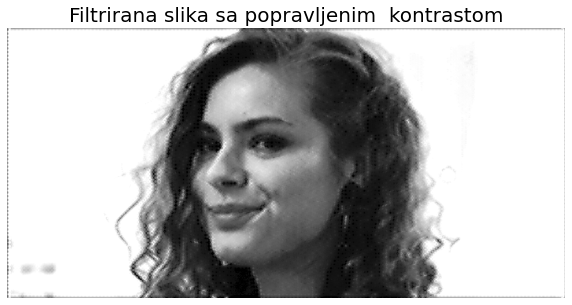

In [24]:
plt.figure(figsize=figsize)
plt.imshow(img_contrast_stretched, cmap='gray')

plt.title('Filtrirana slika sa popravljenim  kontrastom', fontsize=fontsize)
plt.axis('off')
plt.show()

### Poređenje

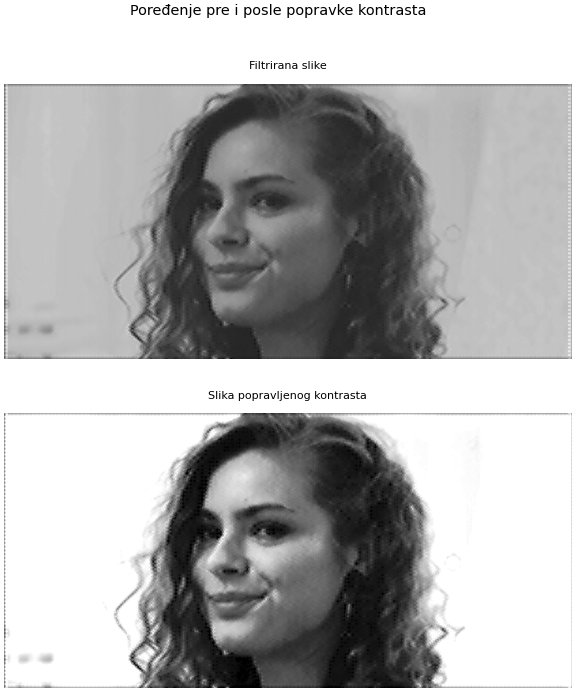

In [25]:
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);


ax[0].imshow(img_filtered, cmap='gray')
ax[0].set_title("Filtrirana slike\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(img_contrast_stretched, cmap='gray')
ax[1].set_title("Slika popravljenog kontrasta\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Poređenje pre i posle popravke kontrasta", fontsize= suptitle_scale * fontsize)
plt.show()

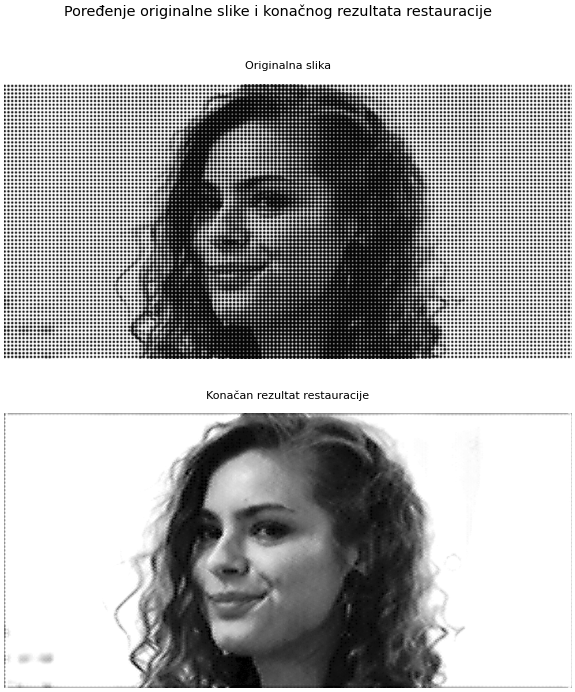

In [26]:
fig, ax = plt.subplots(2, 1, figsize=subplot_figsize, dpi=40);


ax[0].imshow(img, cmap='gray')
ax[0].set_title("Originalna slika\n", fontsize=fontsize)
ax[0].axis('off')

ax[1].imshow(img_contrast_stretched, cmap='gray')
ax[1].set_title("Konačan rezultat restauracije\n", fontsize=fontsize)
ax[1].axis('off')

fig.suptitle("Poređenje originalne slike i konačnog rezultata restauracije", fontsize= suptitle_scale * fontsize)
plt.show()

Apdejtovanje numerisanja jednačina

In [27]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>